<div class="alert alert-info">
   <center>
       <h3>Time Series Multi-Horizon Forecasting (Dashboard) : comment prédire des phénomènes non stationnaires à des horizons de temps multiples ?</h3>
       <br>
      <p>Bonjour et bienvenue à cet atelier datacraft en collaboration avec Danone.</p>
       <p>Vous avez ici un dashboard pour tester le forecasting avec un plot via dash et plotly</p>
</center>

importing Jupyter notebook from datacraft_danone.ipynb


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - D:\Users\amiar\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - D:\Users\amiar\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - D:\Users\amiar\anaconda3\li

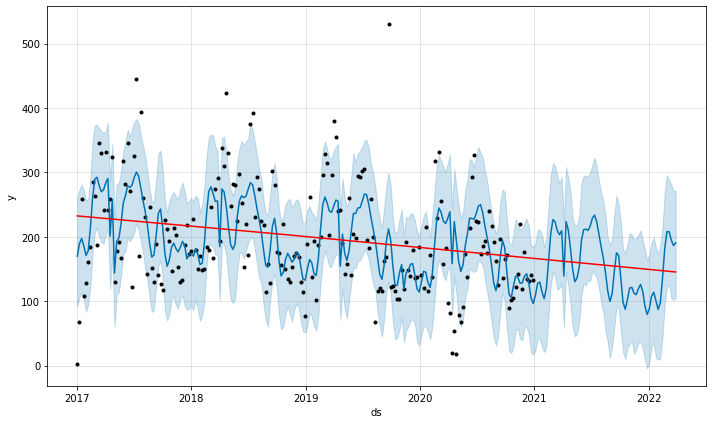

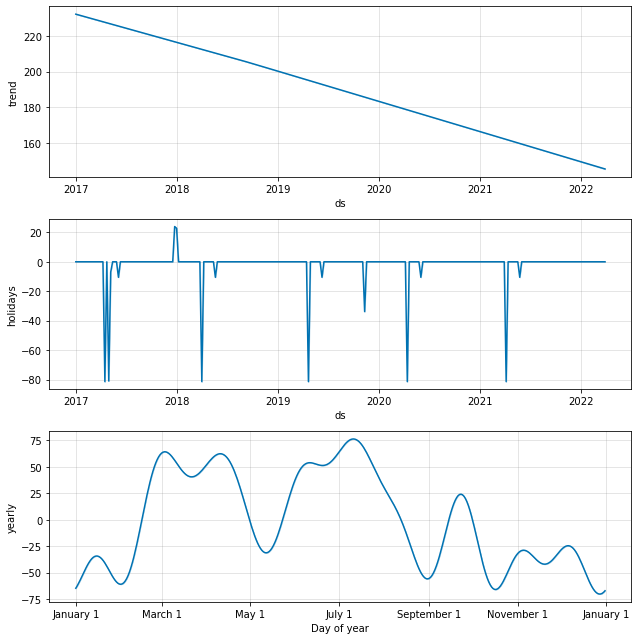

In [1]:
import nbformat
import import_ipynb
import datacraft_danone as dd
import pandas as pd
import numpy as np

from jupyter_dash import JupyterDash
import dash
from dash import dcc
import dash_html_components as html
from dash.dependencies import State,Output, Input

from dash import html
import dash_bootstrap_components as dbc
from dash.exceptions import PreventUpdate

In [2]:
df = pd.read_parquet("./data/forecasting.parquet.gzip")

In [3]:
params = {
    "changepoints" : None, #lorsqu'on donne ce paramètre, le model ne va detecter aucun changepoints (ce n'est pas le paramètre par défaut)
    "n_changepoints" : 25, # nombre de changepoints # pas utile si on spécifie changepoints
    "changepoints_range" : 0.8, # n_changepoints répartis sur 80% sur train set 
    "trend_reg" : 0,
    "trend_reg_threshold" : False,
    "yearly_seasonality" :"auto",
    "weekly_seasonality" :"auto",
    "daily_seasonality": "auto",
    "seasonality_mode" : "additive",
    "seasonality_reg" : 0,
    "n_forecasts" : 1,
    "n_lags" : 0,
    "num_hidden_layers" : 0,
    "d_hidden" : None,
    "ar_reg" : None,
    "learning_rate" : None,
    "epochs" : None,
    "batch_size" : None,
    "loss_func" : "Huber",
    "optimizer" : "AdamW",
    "newer_samples_weight" : 2,
    "newer_samples_start" : 0.0,
    "impute_missing" : True,
    "collect_metrics" :True,
    "normalize" :"auto",
    "global_normalization" :False,
    "global_time_normalization" : True,
    "unknown_data_normalization" : False,
}

selected_columns = {"time_index" : 1,"apparenttemperaturemax" :1,"cos_iso_month" : 0,"cos_iso_week" : 0,"cos_iso_week_of_month": 0,"days_before_next_holiday": 0,"forecasted_volumes": 0,"fu_cod": 0,"future_ordered_volumes_until_saturday_of_current_week": 0,"future_ordered_volumes_until_saturday_of_previous_week": 0,"holiday_day_of_week": 0,"holidays_count_in_week": 0,"iso_month": 0,"iso_week": 0,"iso_week_of_month": 0,"mat_net_weight_value_kg": 0,"ordered_volumes": 1,"precipintensity": 1,"promo_uplift_coefficient": 0}

Ci-dessous, voici une fonction permettant la génération du dashboard via **dash et plotly**.

Celui-ci utilise **neural prophet** mais vous êtes libres de le modifier et d'utiliser **prophet** normal (même si le mode neural est plus performant).

Vous pourrez afficher les courbes des prédictions avec les observations réelles pour différents produits, à différentes dates avec des périodes de prédictions plus ou moins longues au choix.

Néanmoins, il faut prendre en compte un petit détail, certains produits n'ont pas des données complètes (certains ne commencent pas en 2017, mais, parfois des années après).
Il est donc possible de rencontrer des erreurs si l'année choisie est trop ancienne et donc qu'il n'y ait pas de données disponibles à cette date.


In [6]:
def interactive_dashboard(danone, params):
    
    app = JupyterDash(__name__, external_stylesheets=[dbc.themes.COSMO])
    app.layout = html.Div([
        html.H1('Analyse TS Danone avec Prophet'),

        dcc.Dropdown(id='dd_products', options=[{'value':k, 'label': k} for k in danone['product_index'].unique()], multi=True, value=[]),

        dcc.Dropdown(id='dd_year', options=[{'value': k, 'label': k} for k in np.sort(danone['time_index'].apply(lambda date:date.year).unique())]),

        dcc.RadioItems(id='radio_holiday', options=[{'label': 'add holidays effect', 'value': True}, {'label': "don't add holidays effect", 'value': False}]),
        
        dcc.Dropdown(id="dd_periodes", options=[{'value' : k, 'label': str(k) + "semaines"} for k in range(1,53)], multi=True, value=[]),

        dcc.Dropdown(id='dd_reg', options=[{'label': reg, 'value': reg} for reg in danone.columns], multi=True, value=[]),

        dbc.Button("apply changements", id='button'),

        dcc.Graph(id='graph_1')
    ])

    @app.callback(Output('graph_1', 'figure'),
                  Input('button', 'n_clicks'),
                  State('dd_products', 'value'),
                  State('dd_year', 'value'),
                  State('radio_holiday', 'value'),
                  State('dd_periodes', 'value'),
                  State('dd_reg', 'value')
                 )

    def plot_graph1(n_clicks, products, year, holiday_bool, periodes, reg):
        if not n_clicks:
            raise PreventUpdate
        else:
            forecasts = []
            for i in range(len(products)):
                for k in range(len(periodes)):
                    if dd.split_df(dd.prepare_df(danone, products[i], selected_columns)[0],periodes[k],year)[0].empty: 
                        return dash.no_update,'Product {} for year {} is not available, please try another year'.format(products[i], year) 
                    res = dd.train_neural_prophet_model(df = danone,
                                                        params = params,
                                                        product_id = products[i],
                                                        periode = periodes[k],
                                                        date_sep = year)
                    forecasts.append(res[3])
            print(forecasts)

            return dd.plot_my_neural_graph(forecasts = forecasts)

    app.run_server(mode='inline')

Epoch[492/492]: 100%|█| 492/492 [00:18<00:00, 26.48it/s, SmoothL1Loss=0.0296, MAE=1.99, RMSE=2.59, RegLoss=0, MAE_val=2
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 93.103% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 93.103% of the data.
INFO - (NP.df_utils._infer_frequency) -

  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.14E-01, min: 3.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.14E-01, min: 3.00E-01


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.38E-01, min: 2.52E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.38E-01, min: 2.52E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.16E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.16E-01
Epoch[492/492]: 100%|█| 492/492 [00:17<00:00, 27.67it/s, SmoothL1Loss=0.0295, MAE=1.98, RMSE=2.57, RegLoss=0, MAE_val=2
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 85.714% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 85.714% of the data.
INFO - (NP.df_utils._infer_frequency) - Defi

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
NameError: name 'years' is not defined



In [7]:
interactive_dashboard(df,params)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.363% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 99.363% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as W-MON
INFO:NP.df_utils:Dataframe freq automatically defined as W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.206% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 99.206% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override t

  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.41E+00, min: 1.14E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.41E+00, min: 1.14E-01


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.36E-02, min: 1.68E-01
INFO:NP.utils_torch:lr-range-test results: steep: 6.36E-02, min: 1.68E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.08E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.08E-01
Epoch[469/469]: 100%|█| 469/469 [00:16<00:00, 28.17it/s, SmoothL1Loss=0.0113, MAE=41, RMSE=51.7, RegLoss=0, MAE_val=107
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined freq

  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.32E-02, min: 6.50E-01
INFO:NP.utils_torch:lr-range-test results: steep: 4.32E-02, min: 6.50E-01


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.24E-02, min: 2.47E-01
INFO:NP.utils_torch:lr-range-test results: steep: 5.24E-02, min: 2.47E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.10E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 6.10E-02
Epoch[469/469]: 100%|█| 469/469 [00:16<00:00, 27.94it/s, SmoothL1Loss=0.0118, MAE=42.2, RMSE=53.7, RegLoss=0, MAE_val=1
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 90.909% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 90.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 90.909% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 90.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defi

  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.72E-02, min: 3.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.72E-02, min: 3.00E-01


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.14E-01, min: 3.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.14E-01, min: 3.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.58E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 9.58E-02
Epoch[492/492]: 100%|█| 492/492 [00:16<00:00, 30.13it/s, SmoothL1Loss=0.0296, MAE=1.99, RMSE=2.52, RegLoss=0, MAE_val=2
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 80.0% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined freq

  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.14E-01, min: 3.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.14E-01, min: 3.00E-01


  0%|          | 0/108 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.37E-02, min: 2.47E-01
INFO:NP.utils_torch:lr-range-test results: steep: 9.37E-02, min: 2.47E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.02E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.02E-01
Epoch[492/492]: 100%|█| 492/492 [00:16<00:00, 30.72it/s, SmoothL1Loss=0.0295, MAE=1.98, RMSE=2.61, RegLoss=0, MAE_val=2
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 72.727% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 72.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W-MON
INFO:NP.df_utils:Defined frequency is equal to major frequency - W-MON
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 72.727% of the data.
INFO:NP.df_utils:Major frequency W-MON corresponds to 72.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defi

[          ds           y      yhat1   residual1      trend  season_yearly  \
0 2020-01-06  141.119995  21.613970 -119.506025  73.452644     -51.838673   
1 2020-01-13  120.959999  30.750399  -90.209600  70.904823     -40.154427   
2 2020-01-20  215.039993  39.844696 -175.195297  68.357056     -28.512354   
3 2020-01-27  115.919998  47.865765  -68.054234  65.809280     -17.943514   
4 2020-02-03  172.199997  55.479702 -116.720295  63.261463      -7.781759   

   events_additive  event_Armistice 1918  event_Armistice 1945  \
0              0.0                   0.0                   0.0   
1              0.0                   0.0                   0.0   
2              0.0                   0.0                   0.0   
3              0.0                   0.0                   0.0   
4              0.0                   0.0                   0.0   

   event_Ascension  event_Assomption  event_Fête du Travail  \
0              0.0               0.0                    0.0   
1            

In [30]:
dd.plot_residuals(dd.train_prophet_model(df)[4])

AttributeError: module 'datacraft_danone' has no attribute 'plot_residuals'

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
WARNING - (py.warnings._showwarnmsg) - D:\Users\amiar\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - D:\Users\amiar\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


WARNING - (py.warnings._showwarnmsg) - D:\Users\amiar\anaconda3\li

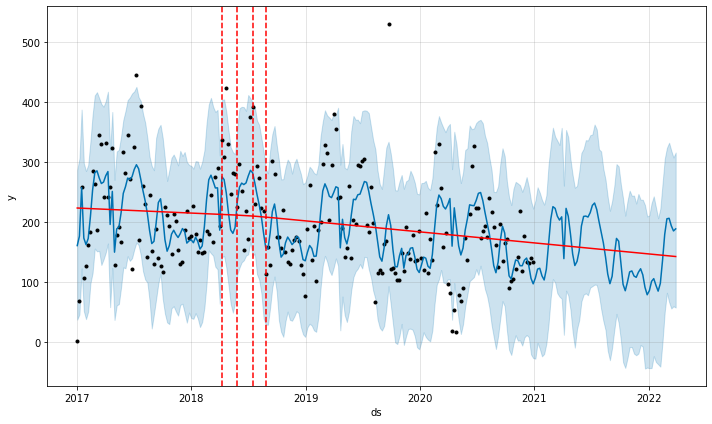

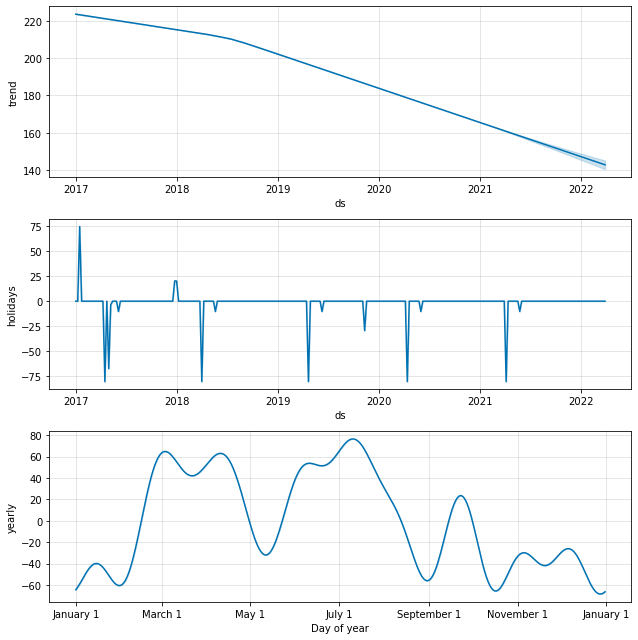

In [15]:
res = dd.train_prophet_model(df)
dd.plot_prophet_made_graph(res[3],res[0])

In [35]:
m, danone, future, forecast, residuals = dd.train_prophet_model(df)

AttributeError: module 'datacraft_danone' has no attribute 'train_prophet_model'